In [1]:
import torch
import matplotlib.pyplot as plt

from src.latexify import latexify

from src.params import Params
from src.holohover_dataset import HolohoverDataset
from src.holohover_model import HolohoverModel
from src.learn import Learn

In [2]:
# pytorch device and random seed
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:
    dev = "cpu"
device = torch.device(dev)
torch.manual_seed(0)

In [3]:
series = '2023_11_22-11_57_44_sysid_h1_old'
encoder_length = 20
prediction_length = 50
dataset = HolohoverDataset(series, encoder_length + prediction_length, with_dX=True, allow_overlapping=False)

In [4]:
def get_prediction_mse(model):

    params = Params(f'models/{model}/params.json')
    params['model']['model_path'] = f'models/{model}/model.pt'
    params['model']['load_model'] = True
    
    model = HolohoverModel(params=params, device=device)

    learn = Learn(params=params, dataset=dataset, model=model, device=device)

    X_prediction_mse = torch.zeros((prediction_length, 6))
    dX_prediction_mse = torch.zeros((prediction_length, 6))
    for i in range(len(dataset)):
        T, X, U, dX = dataset[i]

        with torch.no_grad():
            _, X_predict = learn.predict_system(T.unsqueeze(0), X.unsqueeze(0), U.unsqueeze(0), encoder_length, prediction_length)
            X_predict = X_predict.squeeze(0)

        X_prediction_error = torch.square(X[encoder_length:, :] - X_predict[:, :6])
        X_prediction_mse += X_prediction_error

        dX_model = learn.dX_model(T, torch.cat((X[:encoder_length, :], X_predict[:, :6])), U)
        dX_prediction_error = torch.square(dX[encoder_length:, :] - dX_model[encoder_length:, :6])
        dX_prediction_mse += dX_prediction_error

    X_prediction_mse /= len(dataset)
    dX_prediction_mse /= len(dataset)
    
    return torch.sqrt(X_prediction_mse), torch.sqrt(dX_prediction_mse)

In [5]:
errors = [
    get_prediction_mse('paper/M0'),
    get_prediction_mse('paper/M1'),
    get_prediction_mse('paper/M2'),
    get_prediction_mse('paper/M3'),
    get_prediction_mse('paper/M4'),
]

In [6]:
T, _, _, _ = dataset[0]
T = T[(encoder_length-1):].detach().cpu().numpy()
T -= T[0]

errors = [(torch.cat((torch.zeros(1, 6), error[0])), error[1]) for error in errors]

In [7]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

In [8]:
labels = [
    'M0',
    'M1',
    'M2',
    'M3',
    'M4',
]

line_styles = [
    '-',
    (0, (1, 1)),
    '--',
    ':',
    '-.',
]

model_to_show = [0, 1, 2, 3, 4]

In [9]:
print(f'{prediction_length} prediction steps corresponds to a prediction time of {T[-3]} sec')
for i, error in enumerate(errors):
    print(f'RMSE after {prediction_length} prediction steps: {error[0][-3][0:3]} - {labels[i]}')

50 prediction steps corresponds to a prediction time of 0.20000004768371582 sec
RMSE after 50 prediction steps: tensor([0.0162, 0.0157, 0.5008]) - M0
RMSE after 50 prediction steps: tensor([0.0151, 0.0150, 0.4951]) - M1
RMSE after 50 prediction steps: tensor([0.0129, 0.0114, 0.3910]) - M2
RMSE after 50 prediction steps: tensor([0.0108, 0.0098, 0.3871]) - M3
RMSE after 50 prediction steps: tensor([0.0108, 0.0096, 0.3874]) - M4


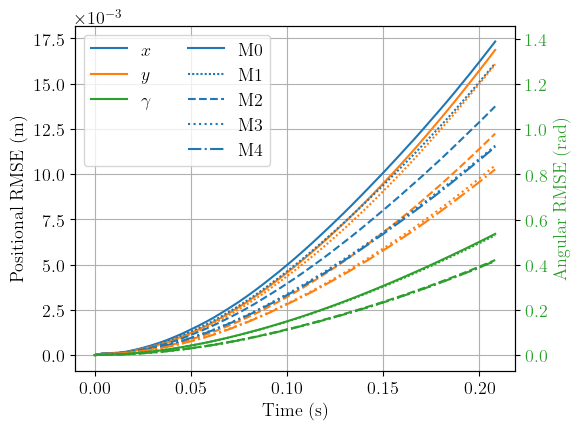

In [10]:
latexify()

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax1 = plt.subplots()

fig.set_figwidth(6)
fig.set_figheight(4.5)

ax1.set_xlabel('Time (\si{s})')
ax1.set_ylabel('Positional RMSE (\si{m})')
ax1.ticklabel_format(axis='y', style='sci', scilimits=(-3, -3))
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = cycle[2]
ax2.set_ylabel(r'Angular RMSE (\si{rad})', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)

lns = ax1.plot(T, errors[model_to_show[0]][0][:, 0].detach().cpu().numpy(), label=r'$x$', color=cycle[0], ls=line_styles[0])
lns += ax1.plot(T, errors[model_to_show[0]][0][:, 1].detach().cpu().numpy(), label=r'$y$', color=cycle[1], ls=line_styles[0])
lns += ax2.plot(T, errors[model_to_show[0]][0][:, 2].detach().cpu().numpy(), label=r'$\gamma$', color=color, ls=line_styles[0])
lns += ax1.plot([], [], label=' ', ls='None', color=cycle[0])
lns += ax1.plot([], [], label=' ', ls='None', color=cycle[0])
for i in model_to_show:
    lns += ax1.plot([], [], label=labels[i], ls=line_styles[i], color=cycle[0])
for i in model_to_show[1:]:
    ax1.plot(T, errors[i][0][:, 0].detach().cpu().numpy(), label=r'$x$', color=cycle[0], ls=line_styles[i])
    ax1.plot(T, errors[i][0][:, 1].detach().cpu().numpy(), label=r'$y$', color=cycle[1], ls=line_styles[i])
    ax2.plot(T, errors[i][0][:, 2].detach().cpu().numpy(), label=r'$\gamma$', color=color, ls=line_styles[i])

ax2.set_ylim(top=1.5)
align_yaxis(ax1, 0, ax2, 0)

labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, ncol=2, loc=2)
ax1.grid()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# fig.savefig('plots/RMSE_pos.pdf')
plt.show()


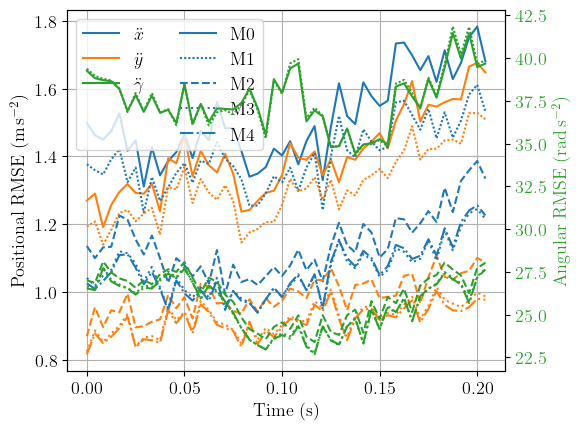

In [11]:
latexify()

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax1 = plt.subplots()

fig.set_figwidth(6)
fig.set_figheight(4.5)

ax1.set_xlabel('Time (\si{s})')
ax1.set_ylabel(r'Positional RMSE (\si{m.s^{-2}})')
# ax1.ticklabel_format(axis='y', style='sci', scilimits=(-3, -3))
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = cycle[2]
ax2.set_ylabel(r'Angular RMSE (\si{rad.s^{-2}})', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)

lns = ax1.plot(T[1:] - T[1], errors[model_to_show[0]][1][:, 3].detach().cpu().numpy(), label=r'$\ddot{x}$', color=cycle[0], ls=line_styles[0])
lns += ax1.plot(T[1:] - T[1], errors[model_to_show[0]][1][:, 4].detach().cpu().numpy(), label=r'$\ddot{y}$', color=cycle[1], ls=line_styles[0])
lns += ax2.plot(T[1:] - T[1], errors[model_to_show[0]][1][:, 5].detach().cpu().numpy(), label=r'$\ddot{\gamma}$', color=color, ls=line_styles[0])
lns += ax1.plot([], [], label=' ', ls='None', color=cycle[0])
lns += ax1.plot([], [], label=' ', ls='None', color=cycle[0])
for i in model_to_show:
    lns += ax1.plot([], [], label=labels[i], ls=line_styles[i], color=cycle[0])
for i in model_to_show[1:]:
    ax1.plot(T[1:] - T[1], errors[i][1][:, 3].detach().cpu().numpy(), label=r'$\ddot{x}$', color=cycle[0], ls=line_styles[i])
    ax1.plot(T[1:] - T[1], errors[i][1][:, 4].detach().cpu().numpy(), label=r'$\ddot{y}$', color=cycle[1], ls=line_styles[i])
    ax2.plot(T[1:] - T[1], errors[i][1][:, 5].detach().cpu().numpy(), label=r'$\ddot{\gamma}$', color=color, ls=line_styles[i])

# ax1.set_ylim(top=1.8, bottom=0.8)
# ax2.set_ylim(top=50, bottom=20)
# align_yaxis(ax1, 0, ax2, 0)

labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, ncol=2, loc=2)
ax1.grid()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# fig.savefig('plots/RMSE_acc.pdf')
plt.show()
